### --------------------------------------------------------------------------------------------------------------------------------------------------------
### Darie-Dragos Mitoiu - 1905367
### Hard-Disk Failure Predictions  v1.0.0 06/02/2021
### Machine Learning models designed to predict Hard-Disks Failure using S.M.A.R.T indicators
### --------------------------------------------------------------------------------------------------------------------------------------------------------

In [131]:
# Importing libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.utils import resample
import sklearn.metrics as metrics
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report, accuracy_score  
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import f1_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix

In [132]:
plt.style.use('fivethirtyeight')

# Fixing random state for reproducibility
np.random.seed(19680801)

In [133]:
df = pd.read_csv("../../../smart/backblaze/model_2017_ST4000DM000.csv")

In [134]:
df_train, df_test = train_test_split(df, test_size=0.2)

### Utility Functions

In [135]:
def model_performance(name, preds_y_model):
    print("Model: " + name) 

    acc = accuracy_score(Y_test, preds_y_model) 
    print("The accuracy is {}".format(acc * 100)) 

    prec = precision_score(Y_test, preds_y_model) 
    print("The precision is {}".format(prec)) 

    rec = recall_score(Y_test, preds_y_model) 
    print("The recall is {}".format(rec)) 

    f1 = f1_score(Y_test, preds_y_model) 
    print("The F1-Score is {}".format(f1)) 

    print("ROC AUC score: %f" % metrics.roc_auc_score(Y_test, preds_y_model))

    MCC = matthews_corrcoef(Y_test, preds_y_model) 
    print("The Matthews correlation coefficient is {}".format(MCC))

### Training Data Exploration

In [136]:
df_train.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
142761,2017-11-21,Z302F0PG,ST4000DM000,4000787030016,0,119.0,232621592.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103785,2017-11-02,S300VTNJ,ST4000DM000,4000787030016,0,116.0,103693392.0,NaN,NaN,96.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73498,2017-10-22,Z3015BSN,ST4000DM000,4000787030016,0,117.0,150626720.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9631,2017-10-03,S301F4DC,ST4000DM000,4000787030016,0,111.0,38125824.0,NaN,NaN,97.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87021,2017-10-27,S300ZAFC,ST4000DM000,4000787030016,0,119.0,224415952.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
df_train.describe()

,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
count,1.426380e+05,142638.000000,142631.000000,1.426310e+05,0.0,0.0,142631.000000,142631.0,142631.000000,142631.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,4.000591e+12,0.058589,115.303875,1.222478e+08,NaN,NaN,93.432585,0.0,99.999509,10.669062,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2.802642e+10,0.234854,3.874610,7.065631e+07,NaN,NaN,2.351016,0.0,0.022148,26.046924,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-1.000000e+00,0.000000,97.000000,0.000000e+00,NaN,NaN,91.000000,0.0,99.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,4.000787e+12,0.000000,114.000000,6.096614e+07,NaN,NaN,91.000000,0.0,100.000000,5.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,4.000787e+12,0.000000,117.000000,1.224158e+08,NaN,NaN,93.000000,0.0,100.000000,8.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,4.000787e+12,0.000000,118.000000,1.835540e+08,NaN,NaN,95.000000,0.0,100.000000,13.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,4.000787e+12,1.000000,120.000000,2.441400e+08,NaN,NaN,100.000000,0.0,100.000000,1113.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
print(df_train.shape)

(142638, 95)


### Testing Data Exploration

In [139]:
df_test.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
13683,2017-10-04,S30111TG,ST4000DM000,4000787030016,0,116.0,107706856.0,NaN,NaN,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133477,2017-11-16,Z305APV3,ST4000DM000,4000787030016,0,120.0,2409880.0,NaN,NaN,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146394,2017-11-23,W3009P6Q,ST4000DM000,4000787030016,0,117.0,139193936.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68870,2017-10-20,Z300XEFR,ST4000DM000,4000787030016,0,114.0,65374704.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54952,2017-10-16,Z3014P4R,ST4000DM000,4000787030016,0,114.0,66635640.0,NaN,NaN,95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [140]:
df_test.describe()

,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
count,3.566000e+04,35660.000000,35654.000000,3.565400e+04,0.0,0.0,35654.000000,35654.0,35654.000000,35654.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,4.000114e+12,0.059450,115.297947,1.221033e+08,NaN,NaN,93.437174,0.0,99.999635,10.543305,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,5.189194e+10,0.236469,3.861476,7.035845e+07,NaN,NaN,2.361330,0.0,0.019092,22.875038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-1.000000e+00,0.000000,96.000000,0.000000e+00,NaN,NaN,91.000000,0.0,99.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,4.000787e+12,0.000000,114.000000,6.104690e+07,NaN,NaN,91.000000,0.0,100.000000,5.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,4.000787e+12,0.000000,117.000000,1.222174e+08,NaN,NaN,92.000000,0.0,100.000000,8.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,4.000787e+12,0.000000,118.000000,1.830594e+08,NaN,NaN,95.000000,0.0,100.000000,13.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,4.000787e+12,1.000000,120.000000,2.441396e+08,NaN,NaN,100.000000,0.0,100.000000,1113.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:
print(df_test.shape)

(35660, 95)


### Training Data Class Label Balance

Text(0.5, 1.0, 'Unbalanced Training Data')

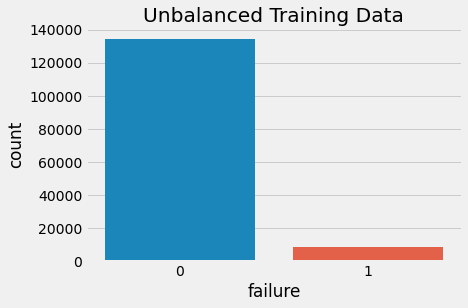

In [142]:
sns.countplot(df_train['failure']).set_title("Unbalanced Training Data")

In [143]:
valid = df_train[df_train['failure'] == 0]
failed = df_train[df_train['failure'] == 1]

print("valid hdds:",len(valid))
print("failing hdds:",len(failed))

valid hdds: 134281
failing hdds: 8357


Random under-sampling:
1    8357
0    8357
Name: failure, dtype: int64


Text(0.5, 1.0, 'Balanced Training Data')

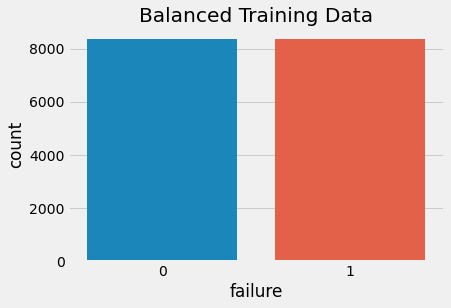

In [144]:
df_class_0_under = valid.sample(len(failed))
df_train = pd.concat([df_class_0_under, failed], axis=0)

print('Random under-sampling:')
print(df_train.failure.value_counts())

sns.countplot(df_train['failure']).set_title("Balanced Training Data")

### Features Selection

In [145]:
# According to Beach (2014), there are 5 s.m.a.r.t features which contain information related to the failure event,
# these features are, smart_5_raw, smart_187_raw, smart_188_raw, smart_197_raw and smart_198_raw
# -----------------------------------------------------------------------------------------------------------------
# SMART 5:   Reallocated_Sector_Count.
# SMART 187: Reported_Uncorrectable_Errors.
# SMART 188: Command_Timeout.
# SMART 197: Current_Pending_Sector_Count.
# SMART 198: Offline_Uncorrectable.
# -----------------------------------------------------------------------------------------------------------------
# Source: https://www.backblaze.com/blog/hard-drive-smart-stats

features = ['date',
            'serial_number',
            'model',
            'capacity_bytes',
            'failure',
            'smart_5_raw',
            'smart_187_raw',
            'smart_188_raw',
            'smart_197_raw',
            'smart_198_raw']

In [146]:
# misc features to be dropped
misc_feat = [fname for fname in df_train if fname not in features] 
misc_feat

['smart_1_normalized',
 'smart_1_raw',
 'smart_2_normalized',
 'smart_2_raw',
 'smart_3_normalized',
 'smart_3_raw',
 'smart_4_normalized',
 'smart_4_raw',
 'smart_5_normalized',
 'smart_7_normalized',
 'smart_7_raw',
 'smart_8_normalized',
 'smart_8_raw',
 'smart_9_normalized',
 'smart_9_raw',
 'smart_10_normalized',
 'smart_10_raw',
 'smart_11_normalized',
 'smart_11_raw',
 'smart_12_normalized',
 'smart_12_raw',
 'smart_13_normalized',
 'smart_13_raw',
 'smart_15_normalized',
 'smart_15_raw',
 'smart_22_normalized',
 'smart_22_raw',
 'smart_183_normalized',
 'smart_183_raw',
 'smart_184_normalized',
 'smart_184_raw',
 'smart_187_normalized',
 'smart_188_normalized',
 'smart_189_normalized',
 'smart_189_raw',
 'smart_190_normalized',
 'smart_190_raw',
 'smart_191_normalized',
 'smart_191_raw',
 'smart_192_normalized',
 'smart_192_raw',
 'smart_193_normalized',
 'smart_193_raw',
 'smart_194_normalized',
 'smart_194_raw',
 'smart_195_normalized',
 'smart_195_raw',
 'smart_196_normalize

In [147]:
df_train.drop(misc_feat,inplace=True,axis=1)

In [148]:
obj = df_train.dtypes[df_train.dtypes == object ].index  
obj

Index(['date', 'serial_number', 'model'], dtype='object')

In [149]:
df_train = df_train.drop(obj,axis=1)

In [150]:
df_train.isnull().sum()

capacity_bytes    0
failure           0
smart_5_raw       0
smart_187_raw     0
smart_188_raw     0
smart_197_raw     0
smart_198_raw     0
dtype: int64

In [151]:
df_train['smart_187_raw'] = df_train['smart_187_raw'].fillna(0)  
df_train['smart_5_raw'] = df_train['smart_5_raw'].fillna(0)
df_train['smart_188_raw'] = df_train['smart_188_raw'].fillna(0)
df_train['smart_197_raw'] = df_train['smart_197_raw'].fillna(0)
df_train['smart_198_raw'] = df_train['smart_198_raw'].fillna(0)
df_train.isnull().sum()

capacity_bytes    0
failure           0
smart_5_raw       0
smart_187_raw     0
smart_188_raw     0
smart_197_raw     0
smart_198_raw     0
dtype: int64

In [152]:
df_train = df_train.drop('capacity_bytes',axis=1)
df_train

,failure,smart_5_raw,smart_187_raw,smart_188_raw,smart_197_raw,smart_198_raw
72740,0,0.0,0.0,0.0,0.0,0.0
176330,0,0.0,0.0,0.0,0.0,0.0
40516,0,0.0,0.0,0.0,0.0,0.0
153906,0,0.0,0.0,0.0,0.0,0.0
105288,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
55121,1,0.0,0.0,0.0,104.0,104.0
2143,1,0.0,0.0,0.0,0.0,0.0
59466,1,0.0,0.0,0.0,0.0,0.0
137,1,0.0,1.0,0.0,0.0,0.0


In [153]:
X_train = df_train.drop('failure',axis=1)
Y_train = df_train['failure']

In [154]:
df_test = df_test[:4088]

valid hdds: 3850
failing hdds: 238


Text(0.5, 1.0, 'Testing Data')

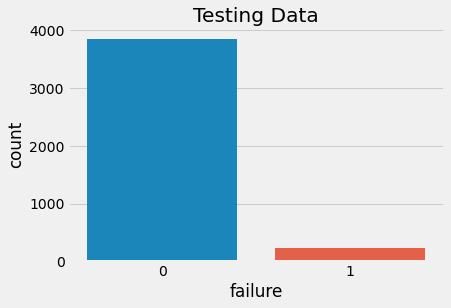

In [155]:
valid_test = df_test[df_test['failure'] == 0]
failed_test = df_test[df_test['failure'] == 1]

print("valid hdds:",len(valid_test))
print("failing hdds:",len(failed_test))

sns.countplot(df_test['failure']).set_title("Testing Data")

In [156]:
df_test.drop(misc_feat,inplace=True,axis=1)

In [157]:
df_test['smart_187_raw'] = df_test['smart_187_raw'].fillna(0)
df_test['smart_5_raw'] = df_test['smart_5_raw'].fillna(0)
df_test['smart_188_raw'] = df_test['smart_188_raw'].fillna(0)
df_test['smart_197_raw'] =df_test['smart_197_raw'].fillna(0)
df_test['smart_198_raw'] = df_test['smart_198_raw'].fillna(0)
df_test.isnull().sum()

date              0
serial_number     0
model             0
capacity_bytes    0
failure           0
smart_5_raw       0
smart_187_raw     0
smart_188_raw     0
smart_197_raw     0
smart_198_raw     0
dtype: int64

In [158]:
df_test = df_test.drop(obj,axis=1)
df_test = df_test.drop('capacity_bytes',axis=1)

In [159]:
X_test = df_test.drop('failure',axis=1)
Y_test = df_test['failure']

In [160]:
print(X_train.shape)
print(Y_train.shape)

(16714, 5)
(16714,)


### Support Vector Machines

In [161]:
svm_model = LinearSVC()
svm_history = svm_model.fit(X_train, Y_train)
preds_y_svm = svm_model.predict(X_test)

C:\Users\Darie\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [162]:
print(classification_report(Y_test, preds_y_svm))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3850
           1       0.55      0.37      0.45       238

    accuracy                           0.95      4088
   macro avg       0.76      0.68      0.71      4088
weighted avg       0.94      0.95      0.94      4088



In [163]:
model_performance("Support Vector Machines", preds_y_svm)

Model: Support Vector Machines
The accuracy is 94.56947162426614
The precision is 0.5493827160493827
The recall is 0.3739495798319328
The F1-Score is 0.445
ROC AUC score: 0.677494
The Matthews correlation coefficient is 0.42608919622399494


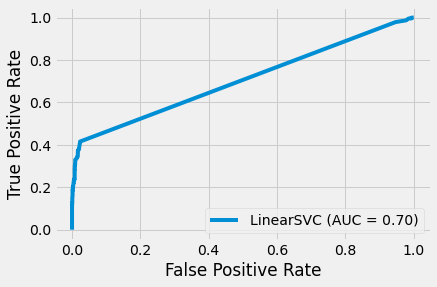

In [164]:
plot_roc_curve(svm_model, X_test, Y_test)

### Random-Forest Model

In [165]:
# random forest model creation 
rfc = RandomForestClassifier() 
rfc.fit(X_train, Y_train) 

# predictions(Notice the caps'P' of yPred to differentiate between model 1 and 2) 
preds_y_rf = rfc.predict(X_test)

In [166]:
model_performance("Random Forest Model", preds_y_rf)

Model: Random Forest Model
The accuracy is 95.10763209393346
The precision is 0.6172839506172839
The recall is 0.42016806722689076
The F1-Score is 0.5
ROC AUC score: 0.702032
The Matthews correlation coefficient is 0.484994184528698


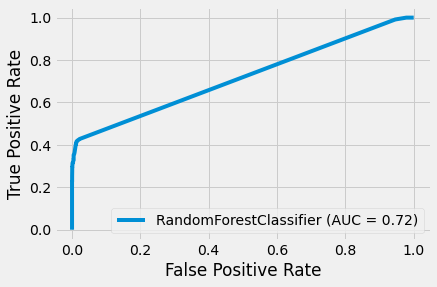

In [167]:
plot_roc_curve(rfc, X_test, Y_test)

In [168]:
# logistic Regression model creation
lr = LogisticRegression() 
lr.fit(X_train, Y_train) 

# predictions(Notice the caps'P' of yPred to differentiate between model 1 and 2) 
preds_y_lr = lr.predict(X_test)

In [169]:
model_performance("Logistic Regression", preds_y_lr)

Model: Logistic Regression
The accuracy is 94.6183953033268
The precision is 0.5548780487804879
The recall is 0.38235294117647056
The F1-Score is 0.4527363184079602
ROC AUC score: 0.681696
The Matthews correlation coefficient is 0.43361836266307996


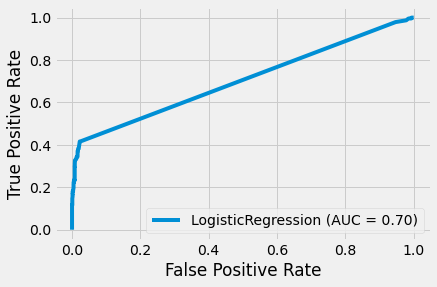

In [170]:
plot_roc_curve(lr, X_test, Y_test)

### Multi-Layer Perceptron

In [171]:
mlp = MLPClassifier(hidden_layer_sizes=100, learning_rate_init=0.1).fit(X_train, Y_train)
preds_y_mlp = mlp.predict(X_test)

In [172]:
model_performance("Multi-Layer Perceptron", preds_y_mlp)

Model: Multi-Layer Perceptron
The accuracy is 94.52054794520548
The precision is 0.5380434782608695
The recall is 0.41596638655462187
The F1-Score is 0.46919431279620855
ROC AUC score: 0.696944
The Matthews correlation coefficient is 0.44486505191105075


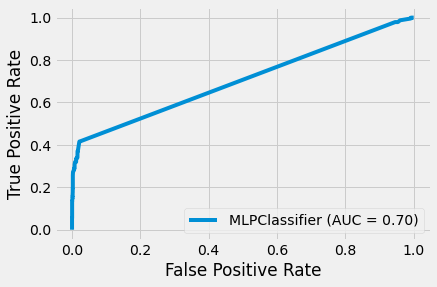

In [173]:
plot_roc_curve(mlp, X_test, Y_test)